# Ecological Index - table information
- Print statistics **related to MPAs**
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- November 2024

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# save tarea and convert to km2
cm2_to_km2 = 100.0 * 100.0 * 1000.0 * 1000.0
tarea = ds_grid.TAREA/cm2_to_km2

## Load EcoIndex Data

In [7]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

### Load "Present Day"

In [8]:
file_in = 'ecoindex_present_day.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

# mask land
ds_eco = ds_eco.where(ds_grid.REGION_MASK == 1)

In [9]:
# keep regional version only
eco_pd = ds_eco.ecoindex_regional_noseal

### Load model data

In [10]:
file_in = 'ecoindex_historical_future.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

# mask land
ds_eco = ds_eco.where(ds_grid.REGION_MASK == 1)

In [11]:
# keep some decades
eco_2000 = ds_eco.ecoindex_regional_decadal.sel(decades=2000)

In [12]:
# keep some decades
eco_2090 = ds_eco.ecoindex_regional_decadal.sel(decades=2090)

### Make masks of "very high" and "high" region

- Very high: EI>= 0.8
- High: EI>=0.6 AND EI<0.8
- Moderate: EI>=0.4 AND EI<0.6
- Low: EI<0.4

In [13]:
#eco_bin_names = ['very_high','high','moderate','low','v_h+h']
eco_bin_names = [1,2,3,4,5]

In [14]:
# combine these into a single array
xlen = len(eco_pd.nlon)
ylen = len(eco_pd.nlat)

In [15]:
# "Present Day" masking
data = eco_pd

# make arrays to fill
eco_1 = data.where(data == 1, other =1)
eco_2 = data.where(data == 1, other =1)
eco_3 = data.where(data == 1, other =1)
eco_4 = data.where(data == 1, other =1)
eco_5 = data.where(data == 1, other =1)

# now just mask by bin
eco_1 = eco_1.where(data >=0.8)
eco_2 = eco_2.where((data >=0.6) & (data <0.8))
eco_3 = eco_3.where((data >=0.4) & (data <0.6))
eco_4 = eco_4.where(data <0.4)
eco_5 = eco_5.where(data >=0.6)

# convert to single array
eco_bins = np.zeros([5,ylen,xlen])
eco_bins[0,:,:] = eco_1.values
eco_bins[1,:,:] = eco_2.values
eco_bins[2,:,:] = eco_3.values
eco_bins[3,:,:] = eco_4.values
eco_bins[4,:,:] = eco_5.values

# convert to xarray
eco_bins_pd = xr.DataArray(eco_bins,dims=('bins','nlat','nlon'))
eco_bins_pd['bins'] = eco_bin_names
eco_bins_pd['nlat'] = data.nlat
eco_bins_pd['nlon'] = data.nlon

In [16]:
# 2000 masking
data = eco_2000

# make arrays to fill
eco_1 = data.where(data == 1, other =1)
eco_2 = data.where(data == 1, other =1)
eco_3 = data.where(data == 1, other =1)
eco_4 = data.where(data == 1, other =1)
eco_5 = data.where(data == 1, other =1)

# now just mask by bin
eco_1 = eco_1.where(data >=0.8)
eco_2 = eco_2.where((data >=0.6) & (data <0.8))
eco_3 = eco_3.where((data >=0.4) & (data <0.6))
eco_4 = eco_4.where(data <0.4)
eco_5 = eco_5.where(data >=0.6)

# convert to single array
eco_bins = np.zeros([5,ylen,xlen])
eco_bins[0,:,:] = eco_1.values
eco_bins[1,:,:] = eco_2.values
eco_bins[2,:,:] = eco_3.values
eco_bins[3,:,:] = eco_4.values
eco_bins[4,:,:] = eco_5.values

# convert to xarray
eco_bins_2000 = xr.DataArray(eco_bins,dims=('bins','nlat','nlon'))
eco_bins_2000['bins'] = eco_bin_names
eco_bins_2000['nlat'] = data.nlat
eco_bins_2000['nlon'] = data.nlon

In [17]:
# 2090 masking
data = eco_2090

# make arrays to fill
eco_1 = data.where(data == 1, other =1)
eco_2 = data.where(data == 1, other =1)
eco_3 = data.where(data == 1, other =1)
eco_4 = data.where(data == 1, other =1)
eco_5 = data.where(data == 1, other =1)

# now just mask by bin
eco_1 = eco_1.where(data >=0.8)
eco_2 = eco_2.where((data >=0.6) & (data <0.8))
eco_3 = eco_3.where((data >=0.4) & (data <0.6))
eco_4 = eco_4.where(data <0.4)
eco_5 = eco_5.where(data >=0.6)

# convert to single array
eco_bins = np.zeros([5,ylen,xlen])
eco_bins[0,:,:] = eco_1.values
eco_bins[1,:,:] = eco_2.values
eco_bins[2,:,:] = eco_3.values
eco_bins[3,:,:] = eco_4.values
eco_bins[4,:,:] = eco_5.values

# convert to xarray
eco_bins_2090 = xr.DataArray(eco_bins,dims=('bins','nlat','nlon'))
eco_bins_2090['bins'] = eco_bin_names
eco_bins_2090['nlat'] = data.nlat
eco_bins_2090['nlon'] = data.nlon

## Load map related masks for analysis

In [18]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [19]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPAs, MPA planning areas, AES)
ccamlr_in = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9',
             'Ross_mpa','Weddell_mpa','Ant_Peninsula_mpa','East_Ant_mpa',
             'AES']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod,
                          ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.Ross_mpa, ds_ccamlr.Weddell_mpa,
                          ds_ccamlr.Ant_Peninsula_mpa, ds_ccamlr.East_Ant_mpa,
                          ds_ccamlr.AES],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [20]:
# make a mask of ALL mpas (adopted and proposed)

# first load the masks and fill the missing values with 0
Ross_mpa = ccamlr_masks.sel(region='Ross_mpa').fillna(0)
Wed_mpa = ccamlr_masks.sel(region='Weddell_mpa').fillna(0)
Ant_Pen_mpa = ccamlr_masks.sel(region='Ant_Peninsula_mpa').fillna(0)
East_Ant_mpa = ccamlr_masks.sel(region='East_Ant_mpa').fillna(0)

# now sum all the masks to get all mpas
mpa_all = Ross_mpa + Wed_mpa + Ant_Pen_mpa + East_Ant_mpa
mpa_all = mpa_all.where(ds_grid.REGION_MASK == 1)

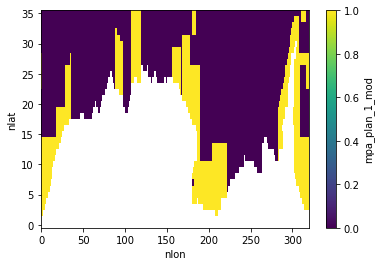

In [21]:
mpa_all.plot()

# Calculate statistics for MPAs

## Hemispheric
- Calculate total fractions High and Exceptional

In [22]:
# multiply binned data by tarea
tarea_pd_bins = eco_bins_pd * tarea
tarea_2000_bins = eco_bins_2000 * tarea
tarea_2090_bins = eco_bins_2090 * tarea

In [23]:
# now mask by all MPA masks
tarea_pd_bins_mpa = tarea_pd_bins * mpa_all
tarea_2000_bins_mpa = tarea_2000_bins * mpa_all
tarea_2090_bins_mpa = tarea_2090_bins * mpa_all

#### Print stats by bin

In [24]:
print('Exceptional+High area fractions INSIDE MPAs')
bin = 5

# calculate and print hemispheric fraction of area that is this bin
print('Observational fraction hemispherically')
frac_pd = tarea_pd_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_pd.values * 100.0)

print('Model 2000s fraction hemispherically')
frac_2000 = tarea_2000_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_2000.values * 100.0)

print('Model 2090s fraction hemispherically')
frac_2090 = tarea_2090_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_2090.values * 100.0)

Exceptional+High area fractions INSIDE MPAs
Observational fraction hemispherically
68.63519752921941
Model 2000s fraction hemispherically
72.71320039603835
Model 2090s fraction hemispherically
69.61766552654252


In [25]:
print('Exceptional area fractions INSIDE MPAs')
bin = 1

# calculate and print hemispheric fraction of area that is this bin
print('Observational fraction hemispherically')
frac_pd = tarea_pd_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_pd.values * 100.0)

print('Model 2000s fraction hemispherically')
frac_2000 = tarea_2000_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_2000.values * 100.0)

print('Model 2090s fraction hemispherically')
frac_2090 = tarea_2090_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_2090.values * 100.0)

Exceptional area fractions INSIDE MPAs
Observational fraction hemispherically
75.91126701279765
Model 2000s fraction hemispherically
83.17798929687858
Model 2090s fraction hemispherically
73.94285706064659


In [26]:
print('High area fractions INSIDE MPAs')
bin = 2

# calculate and print hemispheric fraction of area that is this bin
print('Observational fraction hemispherically')
frac_pd = tarea_pd_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_pd.values * 100.0)

print('Model 2000s fraction hemispherically')
frac_2000 = tarea_2000_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_2000.values * 100.0)

print('Model 2090s fraction hemispherically')
frac_2090 = tarea_2090_bins_mpa.sel(bins=bin).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin).sum(dim=['nlat','nlon'])
print(frac_2090.values * 100.0)

High area fractions INSIDE MPAs
Observational fraction hemispherically
65.70058812847196
Model 2000s fraction hemispherically
67.11088646882061
Model 2090s fraction hemispherically
67.71333441941255


## Regional
- Calculate area weighted average AEV for polynyas regionally
    - ds_ccamlr.mpa_plan_1_mod
    - ds_ccamlr.mpa_plan_3_4
    - ds_ccamlr.mpa_plan_7_mod
    - ds_ccamlr.mpa_plan_8
    - ds_ccamlr.mpa_plan_9

In [27]:
# multiply binned data by tarea and regional masks 
tarea_pd_bins = eco_bins_pd * tarea * ccamlr_masks
tarea_2000_bins = eco_bins_2000 * tarea * ccamlr_masks
tarea_2090_bins = eco_bins_2090 * tarea * ccamlr_masks

In [28]:
# now mask by all MPA masks
tarea_pd_bins_mpa = tarea_pd_bins * mpa_all
tarea_2000_bins_mpa = tarea_2000_bins * mpa_all
tarea_2090_bins_mpa = tarea_2090_bins * mpa_all

#### Exceptional

In [29]:
print('Fraction of EXCEPTIONAL AEV value in region that is also INSIDE MPA')
# keep exceptional points
bin = 1

Fraction of EXCEPTIONAL AEV value in region that is also INSIDE MPA


In [30]:
# calculate and print regional area weighted averages
print('Antarctic peninsula region')
reg = 'mpa_plan_1_mod'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Antarctic peninsula region
Observational fraction
100.0
Model 2000s fraction
100.0
Model 2090s fraction
100.0


In [31]:
# calculate and print regional area weighted averages
print('Weddell region')
reg = 'mpa_plan_3_4'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Weddell region
Observational fraction
41.397593089946376
Model 2000s fraction
100.0
Model 2090s fraction
0.0


In [32]:
# calculate and print regional area weighted averages
print('East Antarctic region')
reg = 'mpa_plan_7_mod'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

East Antarctic region
Observational fraction
53.20814243476902
Model 2000s fraction
77.98891445393252
Model 2090s fraction
55.243560287847004


In [33]:
# calculate and print regional area weighted averages
print('Ross region')
reg = 'mpa_plan_8'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Ross region
Observational fraction
96.94854389374873
Model 2000s fraction
87.32932350614242
Model 2090s fraction
83.33037061938433


In [34]:
# calculate and print regional area weighted averages
print('Amundsen region')
reg = 'mpa_plan_9'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Amundsen region
Observational fraction
0.0
Model 2000s fraction
0.0
Model 2090s fraction
0.0


#### High

In [35]:
print('Fraction of HIGH AEV value in region that is also INSIDE MPA')
# keep exceptional points
bin = 2

Fraction of HIGH AEV value in region that is also INSIDE MPA


In [36]:
# calculate and print regional area weighted averages
print('Antarctic peninsula region')
reg = 'mpa_plan_1_mod'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Antarctic peninsula region
Observational fraction
94.2168372032691
Model 2000s fraction
100.0
Model 2090s fraction
89.2638508028004


In [37]:
# calculate and print regional area weighted averages
print('Weddell region')
reg = 'mpa_plan_3_4'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Weddell region
Observational fraction
88.69122679705097
Model 2000s fraction
94.95754309909347
Model 2090s fraction
100.0


In [38]:
# calculate and print regional area weighted averages
print('East Antarctic region')
reg = 'mpa_plan_7_mod'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

East Antarctic region
Observational fraction
45.78212256837209
Model 2000s fraction
57.280584566242595
Model 2090s fraction
62.4894012657162


In [39]:
# calculate and print regional area weighted averages
print('Ross region')
reg = 'mpa_plan_8'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Ross region
Observational fraction
84.82592633460848
Model 2000s fraction
70.63309611613654
Model 2090s fraction
75.28058681557363


In [40]:
# calculate and print regional area weighted averages
print('Amundsen region')
reg = 'mpa_plan_9'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Amundsen region
Observational fraction
0.0
Model 2000s fraction
0.0
Model 2090s fraction
0.0


#### Exceptional + High

In [41]:
print('Fraction of EXCEPTIONAL and HIGH AEV value in region that is also INSIDE MPA')
# keep exceptional points
bin = 5

Fraction of EXCEPTIONAL and HIGH AEV value in region that is also INSIDE MPA


In [42]:
# calculate and print regional area weighted averages
print('Antarctic peninsula region')
reg = 'mpa_plan_1_mod'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Antarctic peninsula region
Observational fraction
95.7640310441901
Model 2000s fraction
100.0
Model 2090s fraction
92.31776138873902


In [43]:
# calculate and print regional area weighted averages
print('Weddell region')
reg = 'mpa_plan_3_4'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Weddell region
Observational fraction
83.3004382855517
Model 2000s fraction
96.10743302840456
Model 2090s fraction
86.37955359626724


In [44]:
# calculate and print regional area weighted averages
print('East Antarctic region')
reg = 'mpa_plan_7_mod'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

East Antarctic region
Observational fraction
47.50397270085397
Model 2000s fraction
59.30567357807804
Model 2090s fraction
61.48618244822613


In [45]:
# calculate and print regional area weighted averages
print('Ross region')
reg = 'mpa_plan_8'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Ross region
Observational fraction
89.55719154247444
Model 2000s fraction
79.59259614056195
Model 2090s fraction
79.09802137958326


In [46]:
# calculate and print regional area weighted averages
print('Amundsen region')
reg = 'mpa_plan_9'

print('Observational fraction')
avg_pd = tarea_pd_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_pd_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_pd.values*100)

print('Model 2000s fraction')
avg_2000 = tarea_2000_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2000_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2000.values*100)

print('Model 2090s fraction')
avg_2090 = tarea_2090_bins_mpa.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])/tarea_2090_bins.sel(bins=bin,region=reg).sum(dim=['nlat','nlon'])
print(avg_2090.values*100)

Amundsen region
Observational fraction
0.0
Model 2000s fraction
0.0
Model 2090s fraction
0.0
